In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
pipe = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=pipe)
test_set  = datasets.CIFAR100(root='./data', train=False, download=True, transform=pipe)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=1000, shuffle=False)

for batch_x, batch_y in train_loader:
    print(batch_x.shape)
    break


100.0%


torch.Size([64, 3, 32, 32])


In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # First convolutional sequence
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Second convolutional sequence
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Dropout for regularization
        self.dropout_layer = nn.Dropout(p=0.5)
        # Prepare to flatten feature maps
        self.flatten_layer = nn.Flatten()
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.output_layer = nn.Linear(256, 100)

    def forward(self, x):
        x = self.conv_block1(x)         # 3×32×32 → 32×16×16
        x = self.conv_block2(x)         # 32×16×16 → 64×8×8
        x = self.dropout_layer(x)
        x = self.flatten_layer(x)       # 64×8×8 → (batch, 4096)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return self.output_layer(x)     # (batch, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


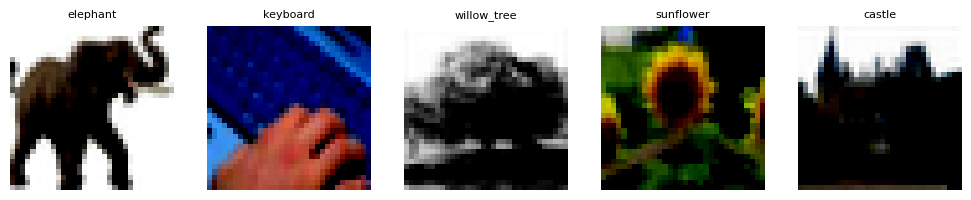

In [8]:
# Retrieve class labels
labels_list = train_set.classes

# Visualize five sample images
plt.figure(figsize=(10, 2))
for idx in range(5):
    img, lbl = train_set[idx + 9]
    # Change tensor from [C, H, W] to [H, W, C]
    img = img.permute(1, 2, 0)

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(labels_list[lbl], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
def run_training(model, data_loader, optim, criterion, num_epochs=5):
    model.train()
    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optim.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch}/{num_epochs} — Total Loss: {epoch_loss:.4f}")

def evaluate(model, data_loader):
    model.eval()
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == targets).sum().item()
            total_samples += targets.size(0)
    accuracy = 100.0 * correct_preds / total_samples
    print(f"Test Accuracy: {accuracy:.2f}%")


In [11]:
# Instantiate and move model to device
net = CustomCNN().to(device)

# Set up optimizer and loss criterion
opt = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train for 10 epochs
run_training(net, train_loader, opt, criterion, num_epochs=10)

# Evaluate on the test set
evaluate(net, test_loader)


Epoch 1/10 — Total Loss: 2737.9443
Epoch 2/10 — Total Loss: 2231.3488
Epoch 3/10 — Total Loss: 2018.4420
Epoch 4/10 — Total Loss: 1870.5283
Epoch 5/10 — Total Loss: 1768.1482
Epoch 6/10 — Total Loss: 1684.2080
Epoch 7/10 — Total Loss: 1618.7659
Epoch 8/10 — Total Loss: 1553.7153
Epoch 9/10 — Total Loss: 1499.8395
Epoch 10/10 — Total Loss: 1456.3587
Test Accuracy: 45.25%


Epoch 1/10 — Total Loss: 2758.6918
Epoch 2/10 — Total Loss: 2232.9110
Epoch 3/10 — Total Loss: 2008.1753
Epoch 4/10 — Total Loss: 1875.8271
Epoch 5/10 — Total Loss: 1781.3853
Epoch 6/10 — Total Loss: 1699.4453
Epoch 7/10 — Total Loss: 1637.8323
Epoch 8/10 — Total Loss: 1572.6105
Epoch 9/10 — Total Loss: 1529.7073
Epoch 10/10 — Total Loss: 1481.2394
Test Accuracy: 45.14%


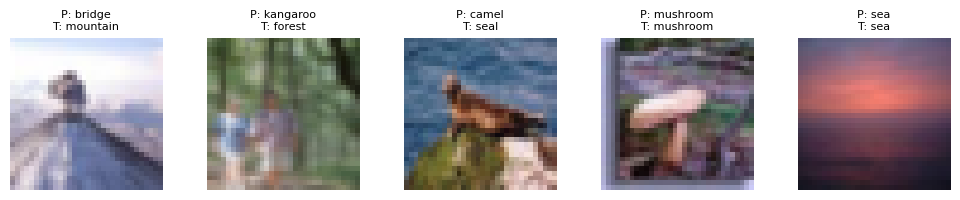

In [15]:
model     = CustomCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.CrossEntropyLoss()


# 1) Fit the network for 10 epochs
run_training(model, train_loader, optimizer, loss_fn, num_epochs=10)
# 2) Evaluate its performance on the test split
evaluate(model, test_loader)  # you may still see low accuracy

# 3) Utility to display a few test samples side‑by‑side with predictions
def plot_predictions(net, loader, num_samples: int = 5):
    net.eval()
    # grab one batch
    imgs, lbls = next(iter(loader))
    imgs, lbls = imgs.to(device), lbls.to(device)

    with torch.no_grad():
        outs = net(imgs)
        preds = outs.argmax(dim=1)

    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        # undo normalization and convert to H×W×C
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"P: {labels_list[preds[i]]}\nT: {labels_list[lbls[i]]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 4) Plot five examples
plot_predictions(model, test_loader, num_samples=5)
